In [2]:
import pandas as pd
import numpy as np
import warnings
from typing import Dict, Iterator, Any
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import os
from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import sys
sys.path.append('/Users/robinfeldmann/TopicAnalysisRUWTweets/src')
from data_schemas import OrigDataSchema, HashedDataSchema, MetaDataSchema
from utility import iterate_dataframes_path, iterate_dataframes, aggregate_data

In [5]:
def create_hashes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates dataframes containing only hashes and tweetids from not duplicates.
    """
    if OrigDataSchema.IS_RETWEET in df.columns:
        df = df[~df.duplicated(subset=OrigDataSchema.TEXT) & ~df[OrigDataSchema.IS_RETWEET]]
    else:
        df =df[~df.duplicated(subset=OrigDataSchema.TEXT)]
        
    df_hashed = df[[OrigDataSchema.TEXT, OrigDataSchema.ID,OrigDataSchema.TIMESTAMP]].copy()
    
    df_hashed[HashedDataSchema.HASH] = df_hashed[OrigDataSchema.TEXT].apply(hash)
    
    
    df_hashed[HashedDataSchema.DATE] = df_hashed[OrigDataSchema.TIMESTAMP].apply(lambda ts: pd.to_datetime(ts[:10]))

    df_hashed = df_hashed.drop(OrigDataSchema.TEXT, axis=1).set_index(HashedDataSchema.ID).drop(OrigDataSchema.TIMESTAMP, axis=1)
    return df_hashed


def aggregate_hash_data(dir_path: str, target_path: str) -> pd.DataFrame:
    """
    Creates aggregated data frame and saves it as csv.
    """

    hashed_dfs = []
    for df in iterate_dataframes(dir_path):
        hashed = create_hashes(df)
        hashed_dfs.append(hashed)

    hashed_df = pd.concat(hashed_dfs)
    hashed_df.to_csv(target_path)

def get_all_hashed_data(path: str) -> pd.DataFrame:
    """
    Loads all hashed dataframes.
    """


    df_hash = pd.read_csv(path)

    df_hashed  = df_hash.sort_values("date")
    
    return df_hashed




def add_is_dupl_to_data() -> None:
    path_data = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/archive/"
    path_hashed = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/AggregatedData/hashed.csv"
    df_hashed = get_all_hashed_data(path_hashed)
    df_hashed = df_hashed[df_hashed.duplicated('hash')]
    for df, path in iterate_dataframes_path(path_data):
        df[OrigDataSchema.IS_DUPL] = df[OrigDataSchema.ID].isin(df_hashed[HashedDataSchema.ID])
        df.to_csv(path)

In [61]:
add_is_dupl_to_data()

100%|██████████| 476/476 [2:02:35<00:00, 15.45s/it]    


In [6]:
path_data = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/archive/"
path_hashed = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/AggregatedData/hashed.csv"
aggregate_hash_data(path_data, path_hashed)
df = get_all_hashed_data(path_hashed)
print(df.shape)
df = df[~df.duplicated('hash')]
print(df.shape)

 12%|█▏        | 58/476 [22:11<2:39:57, 22.96s/it]


KeyboardInterrupt: 

In [51]:
df_agg[MetaDataSchema.ROWS].sum()

70885956

In [53]:
df_agg[MetaDataSchema.DUPLICATED_HASH].sum()

69281004

In [50]:
df_agg[MetaDataSchema.DUPLICATED].sum()

40775304

In [18]:
def iterate_dataframes(path: str) -> Iterator[pd.DataFrame]:
    """
    Iterates over all .csv files in path as pd.DataFrame
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
        csvs = [path + x for x in os.listdir(path) if "csv" in x]
    
        for csv in tqdm(csvs):
            yield pd.read_csv(csv,  lineterminator='\n')

def aggregate_dataframe_with_hash(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Aggregates dataframe to dict.
    """
    df_la = df.groupby("language").count().reset_index()
    languages = df_la['language'].tolist()
    lang_counts = df_la['username'].tolist()
    df['dupl'] = df.duplicated(subset=OrigDataSchema.TEXT) if  OrigDataSchema.IS_RETWEET not in df.columns else df.duplicated(subset=OrigDataSchema.TEXT) | df[OrigDataSchema.IS_RETWEET]
    languages_dupl = [la + "_dupl" for la in languages]
    lang_dupl_counts = df.groupby("language")['dupl'].sum().tolist()

    df[OrigDataSchema.IS_DUPL] = df['dupl'] | df[OrigDataSchema.IS_DUPL]
    languages_dupl_hash = [la + "_hash" for la in languages_dupl]
    lang_dupl_hash_counts =  df.groupby("language")[OrigDataSchema.IS_DUPL].sum().tolist()

    unique_user_count = df[OrigDataSchema.USER_ID].unique().shape[0]
    row_count = df.shape[0]
    duplicated_count = df['dupl'].sum()
    duplicated_hash_count = df[OrigDataSchema.IS_DUPL].sum()

    date = df.iloc[0][OrigDataSchema.TIMESTAMP][:10]
    aggregation = {MetaDataSchema.USERS: unique_user_count,
                  MetaDataSchema.ROWS: row_count,
                  MetaDataSchema.DUPLICATED: duplicated_count,
                  MetaDataSchema.DATE:date,
                  MetaDataSchema.DUPLICATED_HASH: duplicated_hash_count}
    aggregation = {**dict(zip(languages, lang_counts)), **aggregation, **dict(zip(languages_dupl, lang_dupl_counts)), **dict(zip(languages_dupl_hash, lang_dupl_hash_counts))}
    return aggregation

In [62]:
path_data = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/archive/"
path_hashed_aggregated = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/AggregatedData/hashed_agg.csv"

aggregate_data(path_data, path_hashed_aggregated, aggregate_dataframe_with_hash)
df_agg = pd.read_csv(path_hashed_aggregated)


100%|██████████| 476/476 [26:32<00:00,  3.35s/it]    


In [71]:
df_agg[MetaDataSchema.DUPLICATED_HASH].sum()

42393716

In [70]:
df_agg[MetaDataSchema.DUPLICATED].sum()

40775304

In [69]:
df_agg[MetaDataSchema.ROWS].sum()

70885956

In [72]:
def stackplot_duplicates_over_weeks(df: pd.DataFrame, save_path: str = None) -> None:
    """
    Plots sum over weeks of the aggregated df for duplicated and not duplicated columns.
    """


    for col in [MetaDataSchema.ROWS, MetaDataSchema.DUPLICATED, MetaDataSchema.DUPLICATED_HASH]:
        if not col in df.columns:
            raise KeyError(f"Col: {col} not in df.columns.")
    
    #df[MetaDataSchema.DUPLICATED_HASH] = df[MetaDataSchema.ROWS] - df[MetaDataSchema.DUPLICATED_HASH]
    df['weeks'] = df[MetaDataSchema.DATE].apply(pd.to_datetime).apply(lambda x: str(x.year)+ "-" + str(x.week) if len(str(x.week))==2 else str(x.year)+ "-0" + str(x.week))
    
    df_weeks = df.groupby("weeks")[[MetaDataSchema.ROWS, MetaDataSchema.DUPLICATED, MetaDataSchema.DUPLICATED_HASH]].sum()
    df_weeks[MetaDataSchema.ROWS] = df_weeks[MetaDataSchema.ROWS] - df_weeks[MetaDataSchema.DUPLICATED_HASH]
    df_weeks[MetaDataSchema.DUPLICATED_HASH] = df_weeks[MetaDataSchema.DUPLICATED_HASH] - df_weeks[MetaDataSchema.DUPLICATED]
    
    
    fig, ax = plt.subplots()
    ax.stackplot(df_weeks.index, [df_weeks[MetaDataSchema.ROWS],df_weeks[MetaDataSchema.DUPLICATED_HASH], df_weeks[MetaDataSchema.DUPLICATED]],
                 labels=['Not Dupl',"dupl",'hashed' ], alpha=0.8)
    
    index=["" for _ in range(len(df_weeks.index))] 
    index[::4]=list(df_weeks.index)[::4]
    
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ax.set_xticklabels(index)
    ax.legend(loc='upper left')
    ax.set_title('Number of Tweets in Dataset')
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of Tweets sum per Week')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

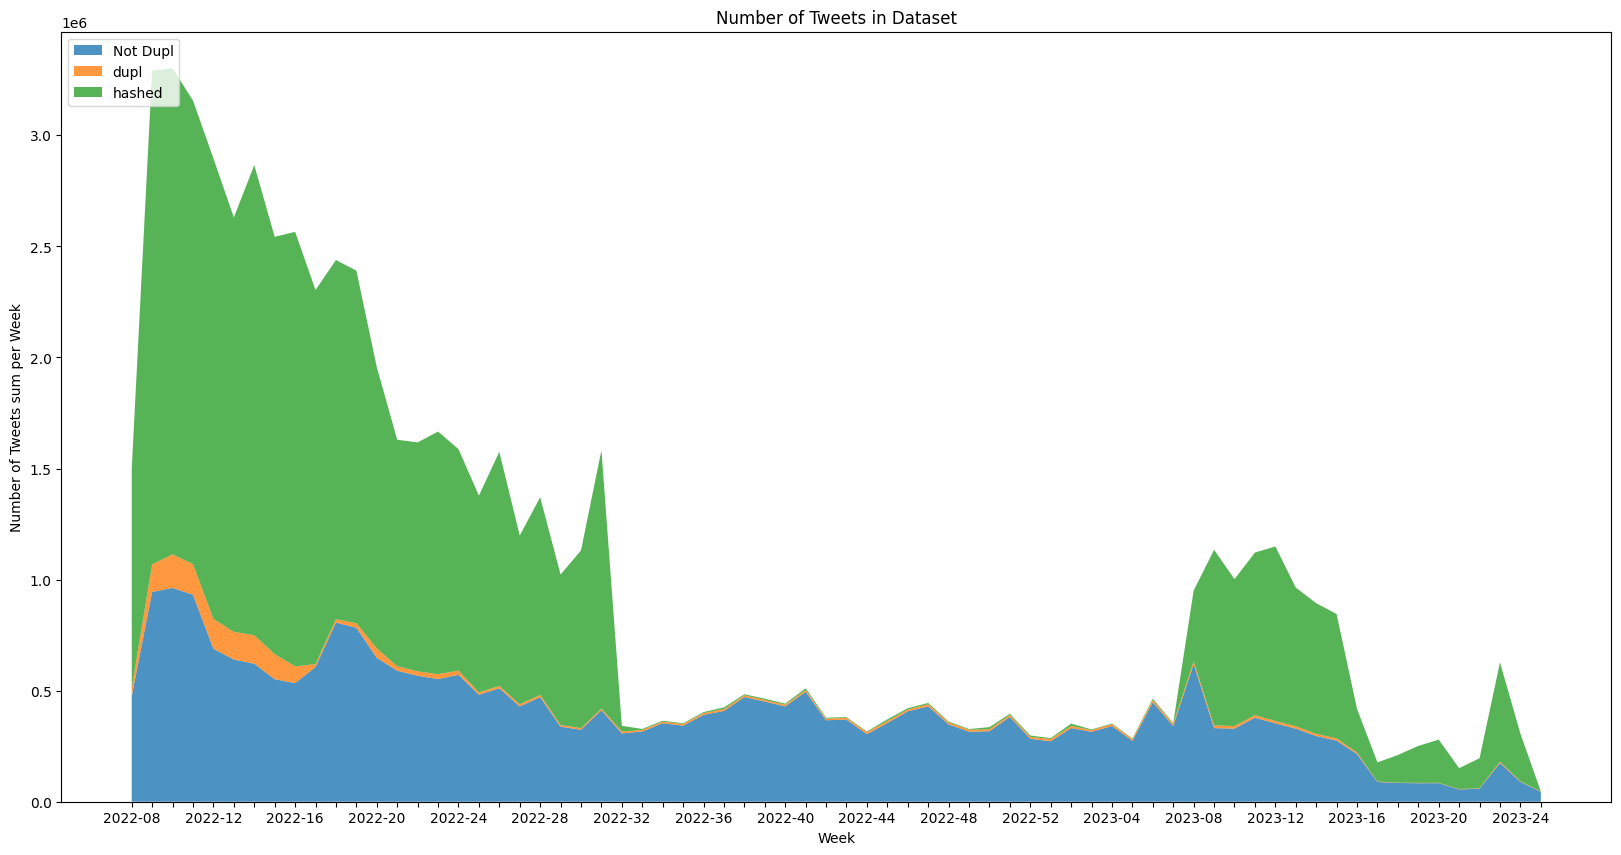

In [73]:
stackplot_duplicates_over_weeks(df_agg)